In [13]:
import itertools
import re

# importaciones de terceros
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [14]:
# Personalizaciones
pd.set_option("display.max_columns", 1000)
plt.style.use('default')
plt.rcdefaults()
sns.set()
pd.read_csv(os.path.dirname(os.getcwd())+'/data/steam.csv').head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,230955,6024,12230,156,10000000-20000000,1850000
1,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Classic,2436,514,13955,10,5000000-10000000,1350000
2,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Classic,21046,1062,153,39,1000000-2000000,1350000
3,70,Half-Life,1998-11-08,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;PvP;Online PvP;Full...,Action,FPS;Classic;1990's,122313,4311,519,99,2000000-5000000,1850000
4,80,Counter-Strike: Condition Zero,2004-03-01,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,Action;FPS;Shooter,22717,2157,1229,37,1000000-2000000,1850000


In [15]:
def remove_non_english(df):
    # mantener solo las filas marcadas como compatibles con inglés
    df = df[df['english'] == 1].copy()    
    # mantener filas que no contienen 3 o más caracteres no ASCII sucesivos
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]    
    # eliminar la columna de inglés, ahora redundante
    df = df.drop('english', axis=1)    
    return df

def calc_rating(row):
    """Calcular la puntuación de calificación basada en el método de SteamDB."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews
    
    # tira la puntuación hacia 50, tira más fuertemente para juegos con pocas reseñas
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

def get_unique(series):
    """Obtener valores únicos de una serie de Pandas que contiene cadenas delimitadas por punto y coma."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def process_cat_gen_tag(df):
    """Procesar las columnas de categorías, géneros y etiquetas de steamspy."""
    # obtener todos los nombres de categorías únicos
    cat_cols = get_unique(df['categories'])
    
    
    cat_cols = [
        'Local Multi-Player',
        'MMO',        
        'Multi-player',
        'Online Co-op',
        'Online Multi-Player',
        'Single-player'
    ]
    
    # crear una nueva columna para cada categoría, con 1s indicando pertenencia y 0s para no miembros
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # repetir para los nombres de columna de géneros (get_unique se usa para encontrar nombres de géneros únicos,

    gen_cols = get_unique(df['genres'])
    
    # solo manteniendo los géneros 'principales' similares a la tienda de steam store
    gen_cols = [
        
        'Action',
        'Adventure',        
        'Casual',        
        'Free to Play',        
        'Indie',
        'Massively Multiplayer',        
        'RPG',
        'Racing',        
        'Simulation',        
        'Sports',
        'Strategy'        
        
    ]
    
    gen_col_names = []
    
    # crear nuevas columnas para cada género con 1s para juegos de ese género
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    
    # eliminar "no-juegos" basados en género
    # si una fila tiene todos ceros en las nuevas columnas de género, probablemente no es un juego, así que eliminar (principalmente software)
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
    
   
        
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    
    return df
def pre_process():
    """Preprocesar el conjunto de datos de Steam para análisis exploratorio."""
    df = pd.read_csv(os.path.dirname(os.getcwd())+'/data/steam.csv')
    
    # mantener solo en inglés
    df = remove_non_english(df)
    
    # mantener solo windows, y eliminar la columna de plataformas
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    
    # mantener el límite inferior de la columna de propietarios, como entero
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
    
    # calcular calificación, así como una proporción simple para comparación
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)
    
    # convertir release_date a tipo datetime y crear una columna separada para release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    
    # procesar columnas de géneros, categorías y etiquetas de steamspy
    df = process_cat_gen_tag(df)
    
    return df

In [16]:
data = pre_process()


data.head()

import warnings
warnings.filterwarnings('ignore')

# Crear una columna para dividir juegos gratuitos y pagados
data['type'] = 'Free'
data.loc[data['price'] > 0, 'type'] = 'Paid'

# asegurar que no haya 0s en las columnas a las que aplicaremos log
df = data[(data['owners'] > 0) & (data['total_ratings'] > 0)].copy()

eda_df = pd.DataFrame(zip(df['rating'],
                          np.log10(df['total_ratings']),
                          np.log10(df['owners']),
                          df['release_year'],
                          df.price,
                          df['type']
                         ),
                      columns=['Rating Score', 'Total Ratings (log)', 'Owners (log)', 'Release Year', 'Current Price', 'Type'])

eda_df

,Rating Score,Total Ratings (log),Owners (log),Release Year,Current Price,Type
0,96.283543,5.374710,7.00000,2000,1850000,Paid
1,78.850120,3.469822,6.69897,2001,1350000,Paid
2,92.853459,4.344549,6.00000,1999,1350000,Paid
3,95.189659,5.102516,6.30103,1998,1850000,Paid
4,89.158999,4.395746,6.00000,2004,1850000,Paid
...,...,...,...,...,...,...
860,95.265436,4.582154,5.69897,2024,3750000,Paid
861,57.448744,4.720432,6.00000,2023,19000000,Paid
862,65.569796,4.615950,6.00000,2024,8100000,Paid
863,92.204169,4.541978,6.00000,2024,3300000,Paid


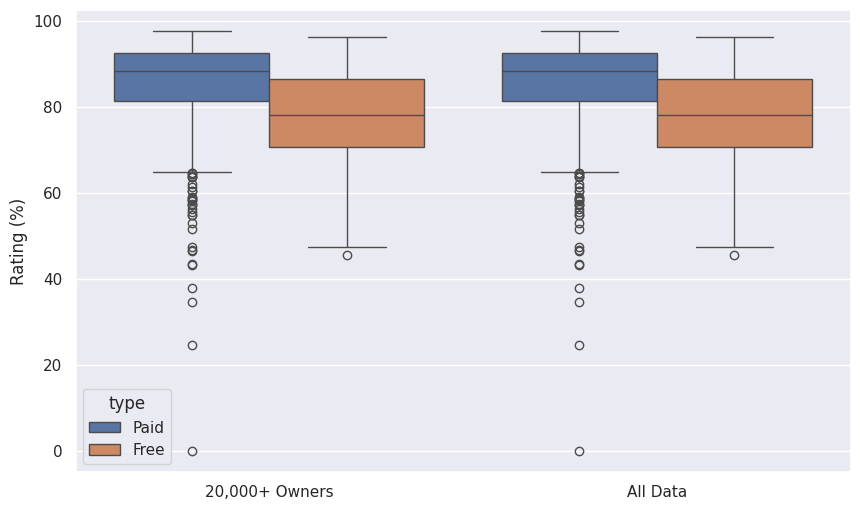

In [17]:
#esta linea nos da un resumen general usando la libreria seaborn
#sns.pairplot(eda_df, hue='Type')
"QUIEN TIENE MEJORES CALIFICACIONES JUEGOS GRATIS VS JUEGOS PAGOS"

plt.show()
fig = plt.figure(figsize=(10,6))

dfa = data[data.owners >= 20000].copy()
dfa['subset'] = '20,000+ Owners'

dfb = data.copy()
dfb['subset'] = 'All Data'

ax = sns.boxplot(x='subset', y='rating', hue='type', data=pd.concat([dfa, dfb]))

ax.set(xlabel='', ylabel='Rating (%)')
plt.show()


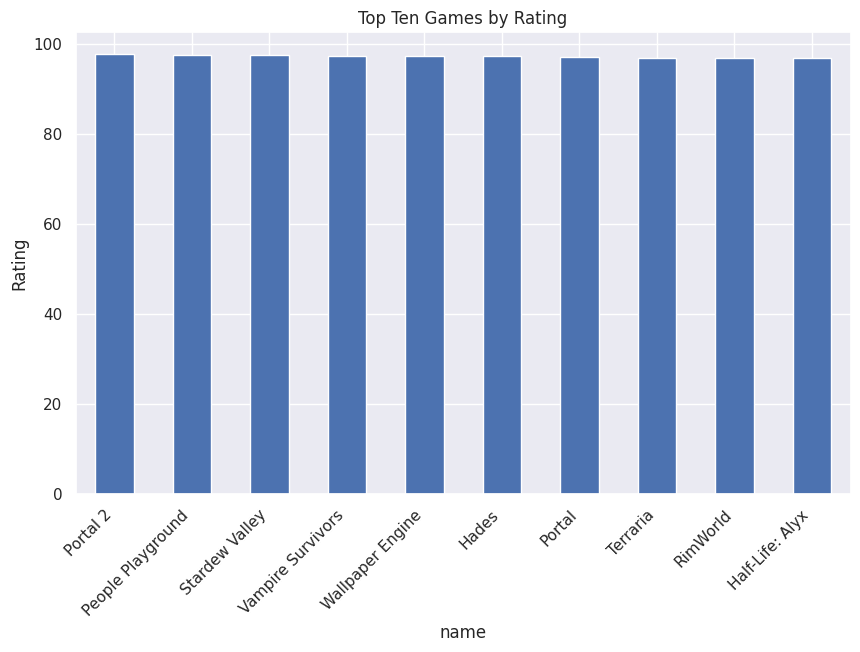

In [18]:
"MEJORES 10 JUEGOS SEGUN SU SCORE Y A QUE GENERO PERTENECEN"
display_cols = ['name', 'developer', 'publisher', 'release_year', 'genres', 'average_playtime', 'owners', 'rating', 'price']
top_ten = df.sort_values(by='rating', ascending=False).head(10) #el 10 define la cantidad de juegos cambiar para mas
top_ten.plot(x='name', y='rating', kind='bar', figsize=(10, 6), legend=False)
plt.ylabel('Rating')
plt.title('Top Ten Games by Rating')
plt.xticks(rotation=45, ha='right')
plt.show()

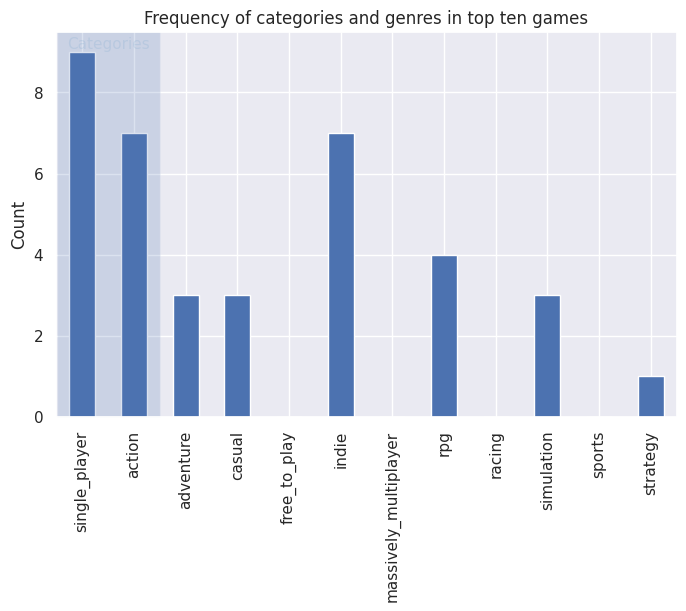

In [19]:
# almacenando las columnas de categoría y género en una variable, ya que las accederemos con frecuencia
cat_gen_cols = df.columns[-13:-1]
ax = top_ten[cat_gen_cols].sum().plot.bar(figsize=(8,5))
ax.fill_between([-.5, 1.5], 10, alpha=.2)
ax.text(0.5, 9.1, 'Categories', fontsize=11, color='tab:blue', alpha=.10, horizontalalignment='center') #valores del plot cambiar si se cambian la cantidad de juegos
ax.set_ylim([0, 9.5])
ax.set_ylabel('Count')
ax.set_title('Frequency of categories and genres in top ten games')
plt.show()

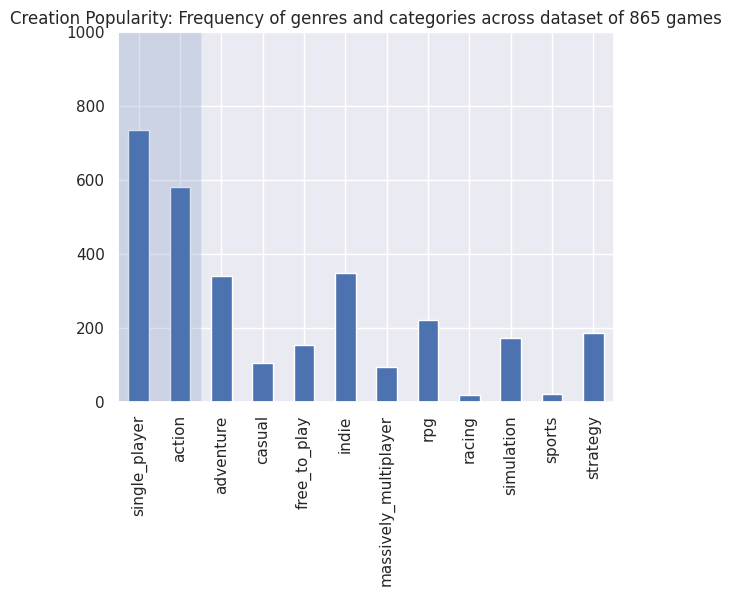

In [20]:
"QUE CATEGORIA TIENE MAS JUEGOS"
ax = df[cat_gen_cols].sum().plot.bar()
ax.fill_between([-.5, 1.5], 7000, alpha=.2)   
ax.set_ylim([0, 1000])
ax.set_ylim([0, 1000]) #por defecto el dataframe de prueba tiene tamaño 1000
ax.set_title(f'Creation Popularity: Frequency of genres and categories across dataset of {df.shape[0]:,} games')
plt.show()

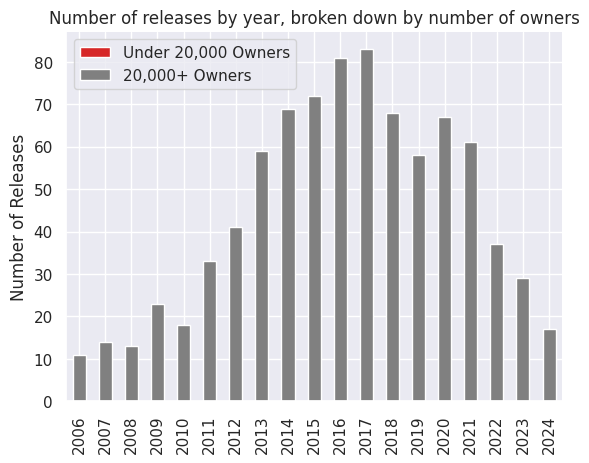

In [21]:
df = data.copy()

years = []
lt_20k = []
gt_20k = []

for year in sorted(df['release_year'].unique()):
    if year < 2006:
        # very few releases in data prior to 2006, and we're still in 2019 (at time of writing)
        # so ignore these years
        continue

    # subset dataframe by year
    year_df = df[df.release_year == year]

    # calculate total with less than 20,000 owners, and total with 20,000 or more
    total_lt_20k = year_df[year_df.owners < 20000].shape[0]
    total_gt_20k = year_df[year_df.owners >= 20000].shape[0]

    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)

owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                         columns=['year', 'Under 20,000 Owners', '20,000+ Owners'])

ax = owners_df.plot(x='year', y=[1, 2], kind='bar', stacked=True, color=['tab:red', 'gray'])

ax.set_xlabel('')
ax.set_ylabel('Number of Releases')
ax.set_title('Number of releases by year, broken down by number of owners')
sns.despine()
plt.show()

In [22]:
# Crear una tabla de juegos en la base de datos
from sqlalchemy import create_engine
from dotenv import load_dotenv
load_dotenv()

db= create_engine('mysql+mysqlconnector://'+os.getenv('DB_USER')+':'+os.getenv('PASSWORD')+'@'+os.getenv('HOST')+':'+'3306'+'/'+os.getenv('DATABASE'), echo=False)
dfa.to_sql(name='games', con=db, if_exists='replace', index=False)

print("Tablas Creadas...")

Tablas Creadas...


In [23]:
#Si deseamos modificar algo o hacer una consulta a la base de datos

from MysqlConector import MysqlConnector
db = MysqlConnector()

# Ejecutar una consulta SELECT
result = db.raw_select("SELECT * FROM games")
print(result)

# Ejecutar una consulta UPDATE
#rows_affected = db.raw_update("UPDATE games SET rating = value1 WHERE condition")
#print(rows_affected)

# Hacer commit de la transacción
db.commit()

# Cerrar la conexión
db.close()


[(10, 'Counter-Strike', datetime.datetime(2000, 11, 1, 0, 0), 'Valve', 'Valve', 0, 'Action', 230955, 6024, 12230, 156, 10000000, 1850000, 236979, 0.9745800260782601, 96.28354303431527, 2000, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'Paid', '20,000+ Owners'), (40, 'Deathmatch Classic', datetime.datetime(2001, 6, 1, 0, 0), 'Valve', 'Valve', 0, 'Action', 2436, 514, 13955, 10, 5000000, 1350000, 2950, 0.8257627118644068, 78.85012013674191, 2001, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'Paid', '20,000+ Owners'), (50, 'Half-Life: Opposing Force', datetime.datetime(1999, 11, 1, 0, 0), 'Gearbox Software', 'Valve', 0, 'Action', 21046, 1062, 153, 39, 1000000, 1350000, 22108, 0.9519630902840601, 92.85345895674027, 1999, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'Paid', '20,000+ Owners'), (70, 'Half-Life', datetime.datetime(1998, 11, 8, 0, 0), 'Valve', 'Valve', 0, 'Action', 122313, 4311, 519, 99, 2000000, 1850000, 126624, 0.9659543214556482, 95.18965919123393, 1998, 0,